# Create Dataset

In [87]:
import torchvision
torchvision.__version__

'0.15.2+cpu'

In [88]:

import os
import matplotlib.pylab as plt
import torch
from PIL import Image, ImageDraw
from torch.utils.data import Dataset
import glob
import numpy as np
torch.manual_seed(0)
%matplotlib inline

In [89]:
path2data = "../data/interim/grasp/cornell/"

def _process_bboxes(name):
    '''Create a list with the coordinates of the grasping rectangles. Every 
    element is either x or y of a vertex.'''
    with open(name, 'r') as f:
        bboxes = list(map(
              lambda coordinate: float(coordinate), f.read().strip().split()))
    return bboxes


def create_image_list():
    # Creating a list with all the image paths
    folders = range(1,11)
    folders = ['0'+str(i) if i<10 else '10' for i in folders]
    filenames = []
    for i in folders:
        for name in glob.glob(os.path.join(path2data, i, 'pcd'+i+'*r.png')):
            filenames.append(name)
    return filenames

def load_img_label(filename):    
    label_file = filename[:-5]+'cpos.txt'
    bboxes = _process_bboxes(label_file)
    label = np.array(bboxes)
    label = label.reshape(-1,8)
    label_clean = []        
    for box in label:
        if not np.isnan(box).any():
            label_clean.append(box.tolist())
    label_clean = np.array(label_clean).reshape(-1).tolist()          
    img = Image.open(filename)
    return img,label_clean

def show_img_label(img,label, thickness=2, size=50):  
    img = img.copy()
    plt.figure(figsize=(size, size))
    # draw a plolygon
    draw = ImageDraw.Draw(img) 
    draw.polygon(label[-8:], outline="blue")    
    plt.imshow(np.asarray(img))


In [90]:
class Cornell_Grasp_dataset(Dataset):
    def __init__(self, path2data, transform, trans_params):      
        pass    
      
    def __len__(self):
        # return size of dataset
        return len(self.fullPath2img)
      
    def __getitem__(self, idx):
        pass

In [91]:
def __init__(self, path2data, transform=None, trans_params=None):      
    # Creating a list with all the image paths
    folders = range(1,11)
    folders = ['0'+str(i) if i<10 else '10' for i in folders]
    self.fullPath2img = []
    for i in folders:
        for name in glob.glob(os.path.join(path2data, i, 'pcd'+i+'*r.png')):
            self.fullPath2img.append(name)
    self.transform = transform
    self.trans_params=trans_params

In [92]:

def __getitem__(self, idx):
    # load PIL image  
    image, label = load_img_label(self.fullPath2img[idx])
    label = torch.tensor(label)
    # transform to tensor
    if self.transform:
        image,label = self.transform(image,label,self.trans_params)

    return image, label

In [93]:
Cornell_Grasp_dataset.__init__=__init__
Cornell_Grasp_dataset.__getitem__=__getitem__

In [94]:
import torchvision.transforms.functional as TF

def resize_img_label(image,label,target_size=(256,256)):
    w_orig,h_orig = image.size   
    w_target,h_target = target_size
    label = label.view(-1,2)
    # resize image and label
    image_new = TF.resize(image,target_size)
    for i in range(len(label)):
        x, y = label[i]
        label[i][0] = x/w_orig*w_target
        label[i][1] = y/h_orig*h_target     
    label = label.view(-1,8)
    return image_new,label

def transformer(image, label, params):
    image,label=resize_img_label(image,label,params["target_size"]) 
    if params["sample_output"]:
        # randoom choose a grasp to be the ground truth      
        index = random.randint(0, len(label) -1)
        label = label[index]  
    image=TF.to_tensor(image)
    return image, label

def collate_fn(batch):
    imgs, labels = list(zip(*batch))
    targets = []
    for i in range(len(labels)):
        label = labels[i]
        target = torch.zeros(label.shape[0], label.shape[1] + 1)
        target[:,0] = i
        target[:, 1:] = label
        targets.append(target)

    targets = torch.cat(targets, 0)
    imgs = torch.stack([img for img in imgs])
    return imgs, targets, 

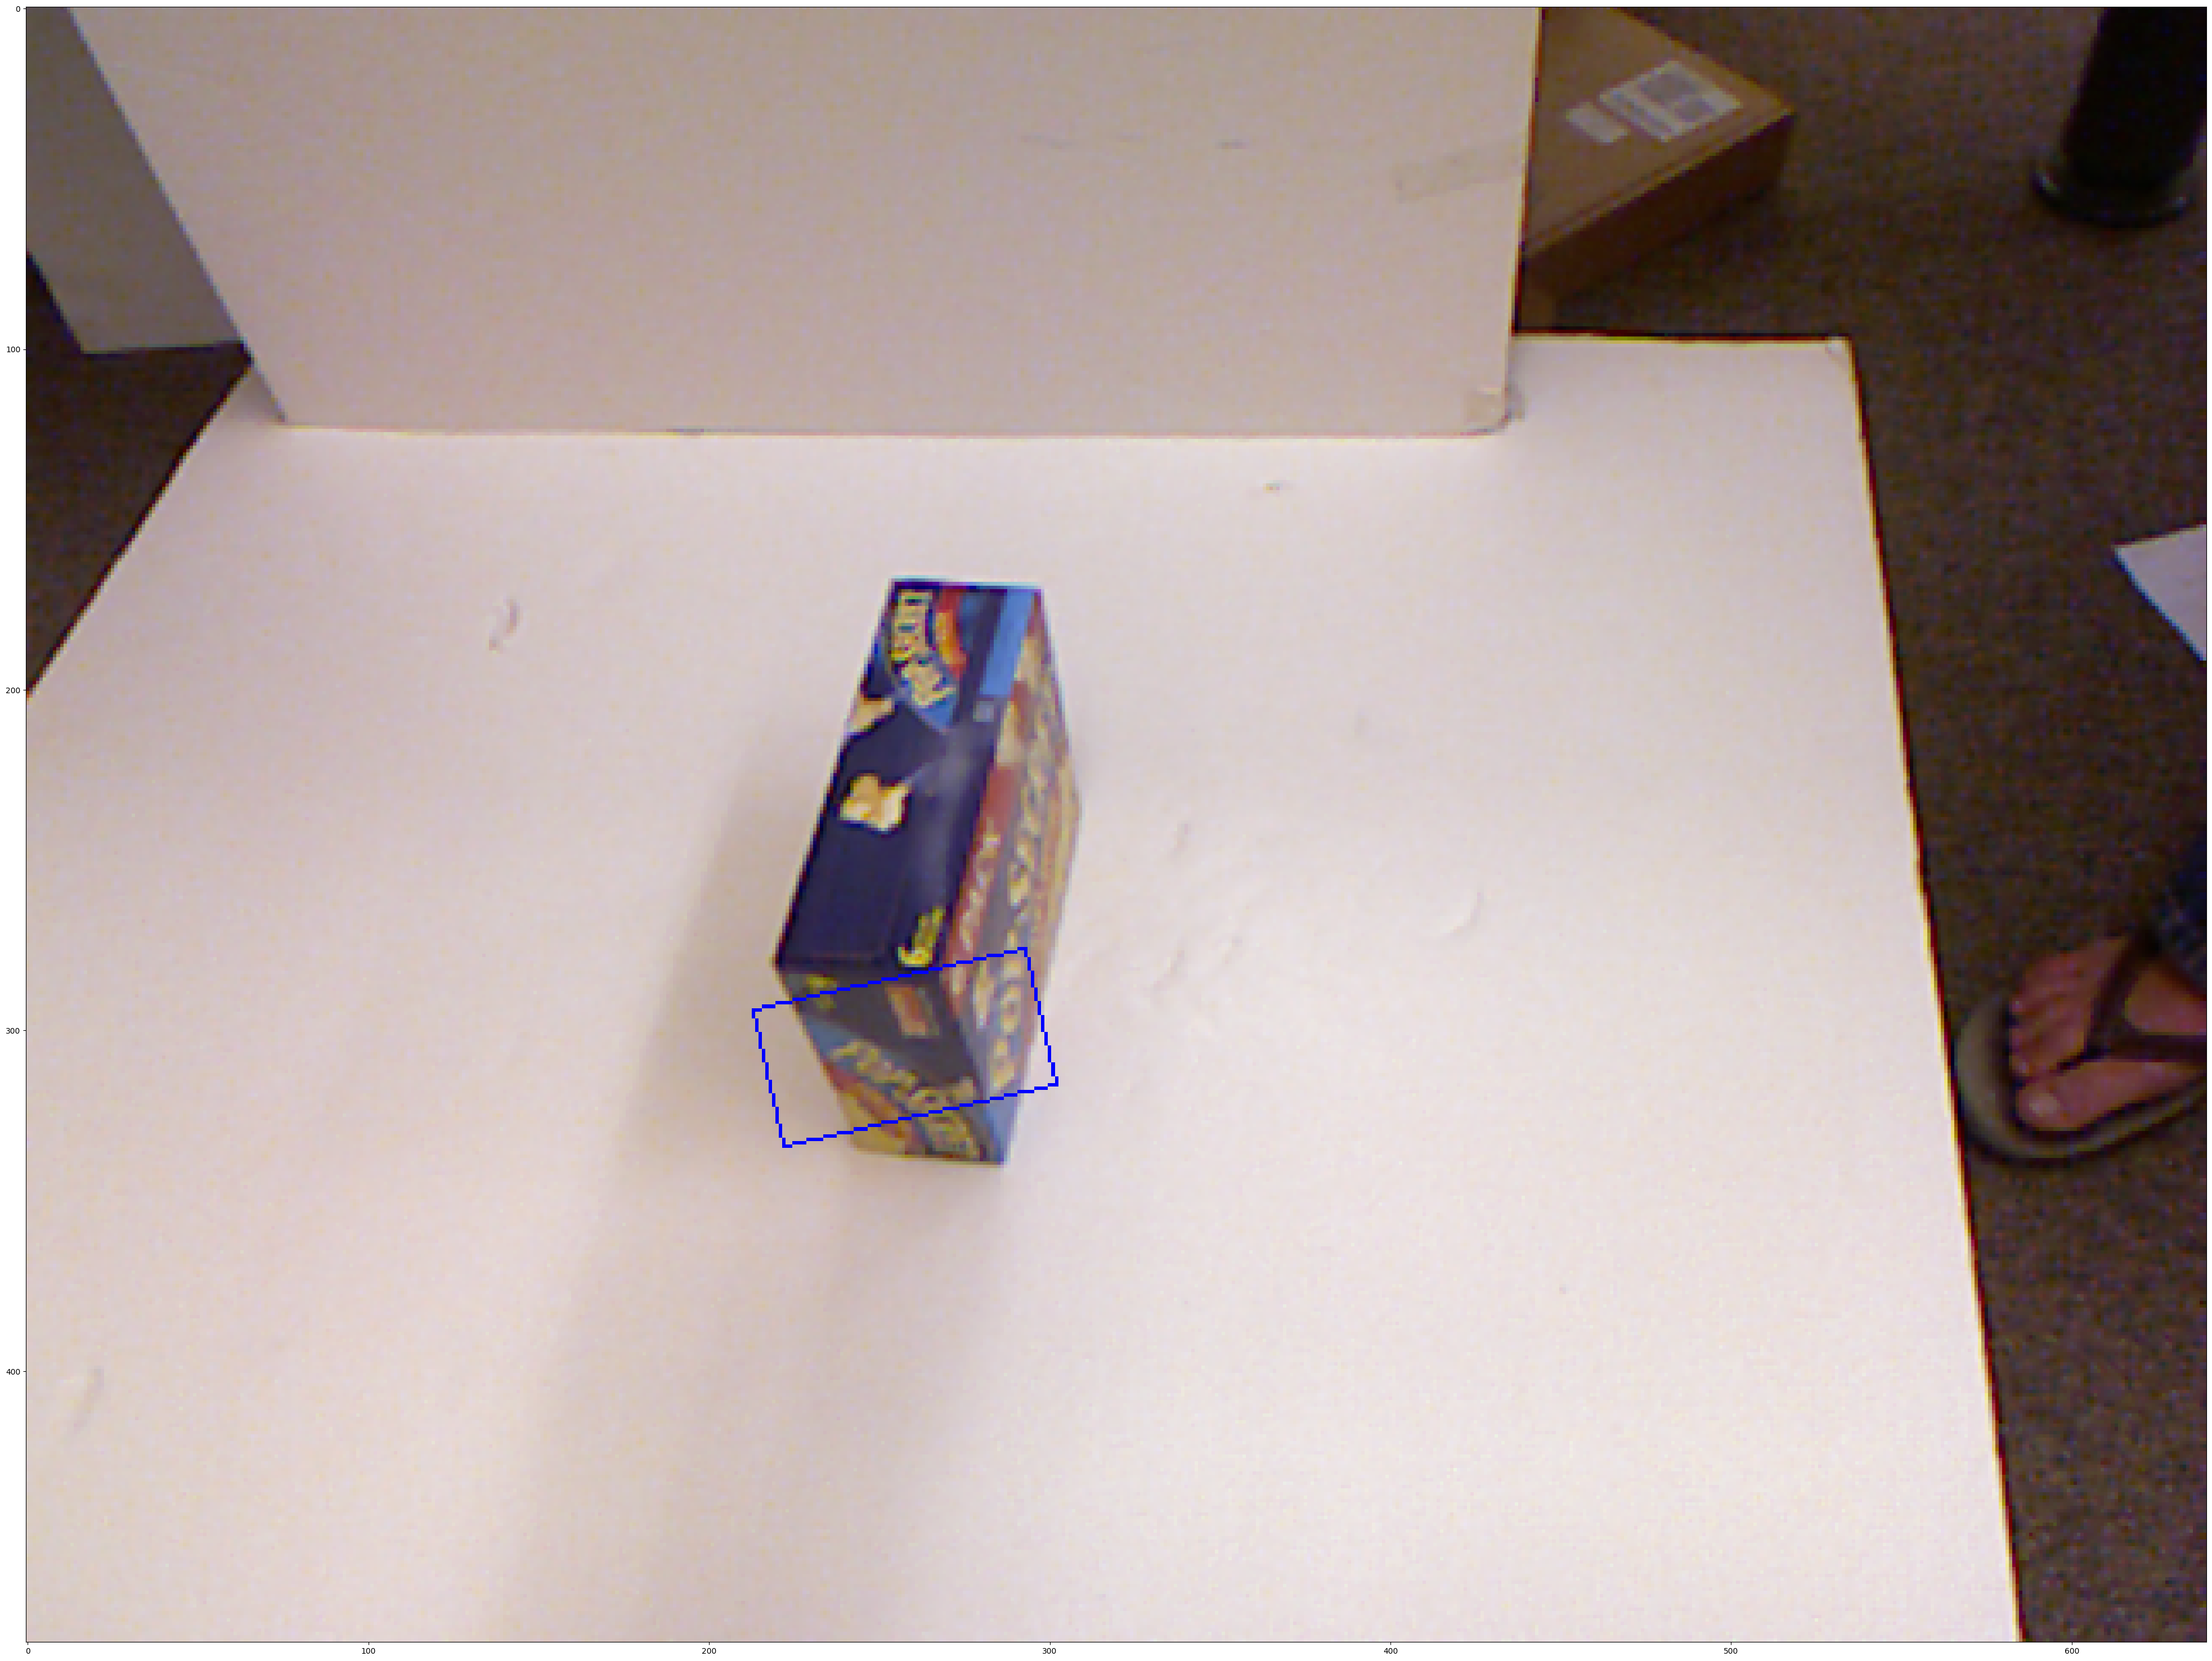

In [95]:
# test transformer
import random
np.random.seed(0)
random.seed(0)

params = {
    "target_size" : (256, 256),
    "sample_output" : True
}

filenames = create_image_list()
f1 = filenames[42]

img, label = load_img_label(f1)

show_img_label(img,label)





tensor([120.8000, 168.5877,  88.8000, 178.1333,  85.2000, 156.8000, 117.2000,
        147.2544])


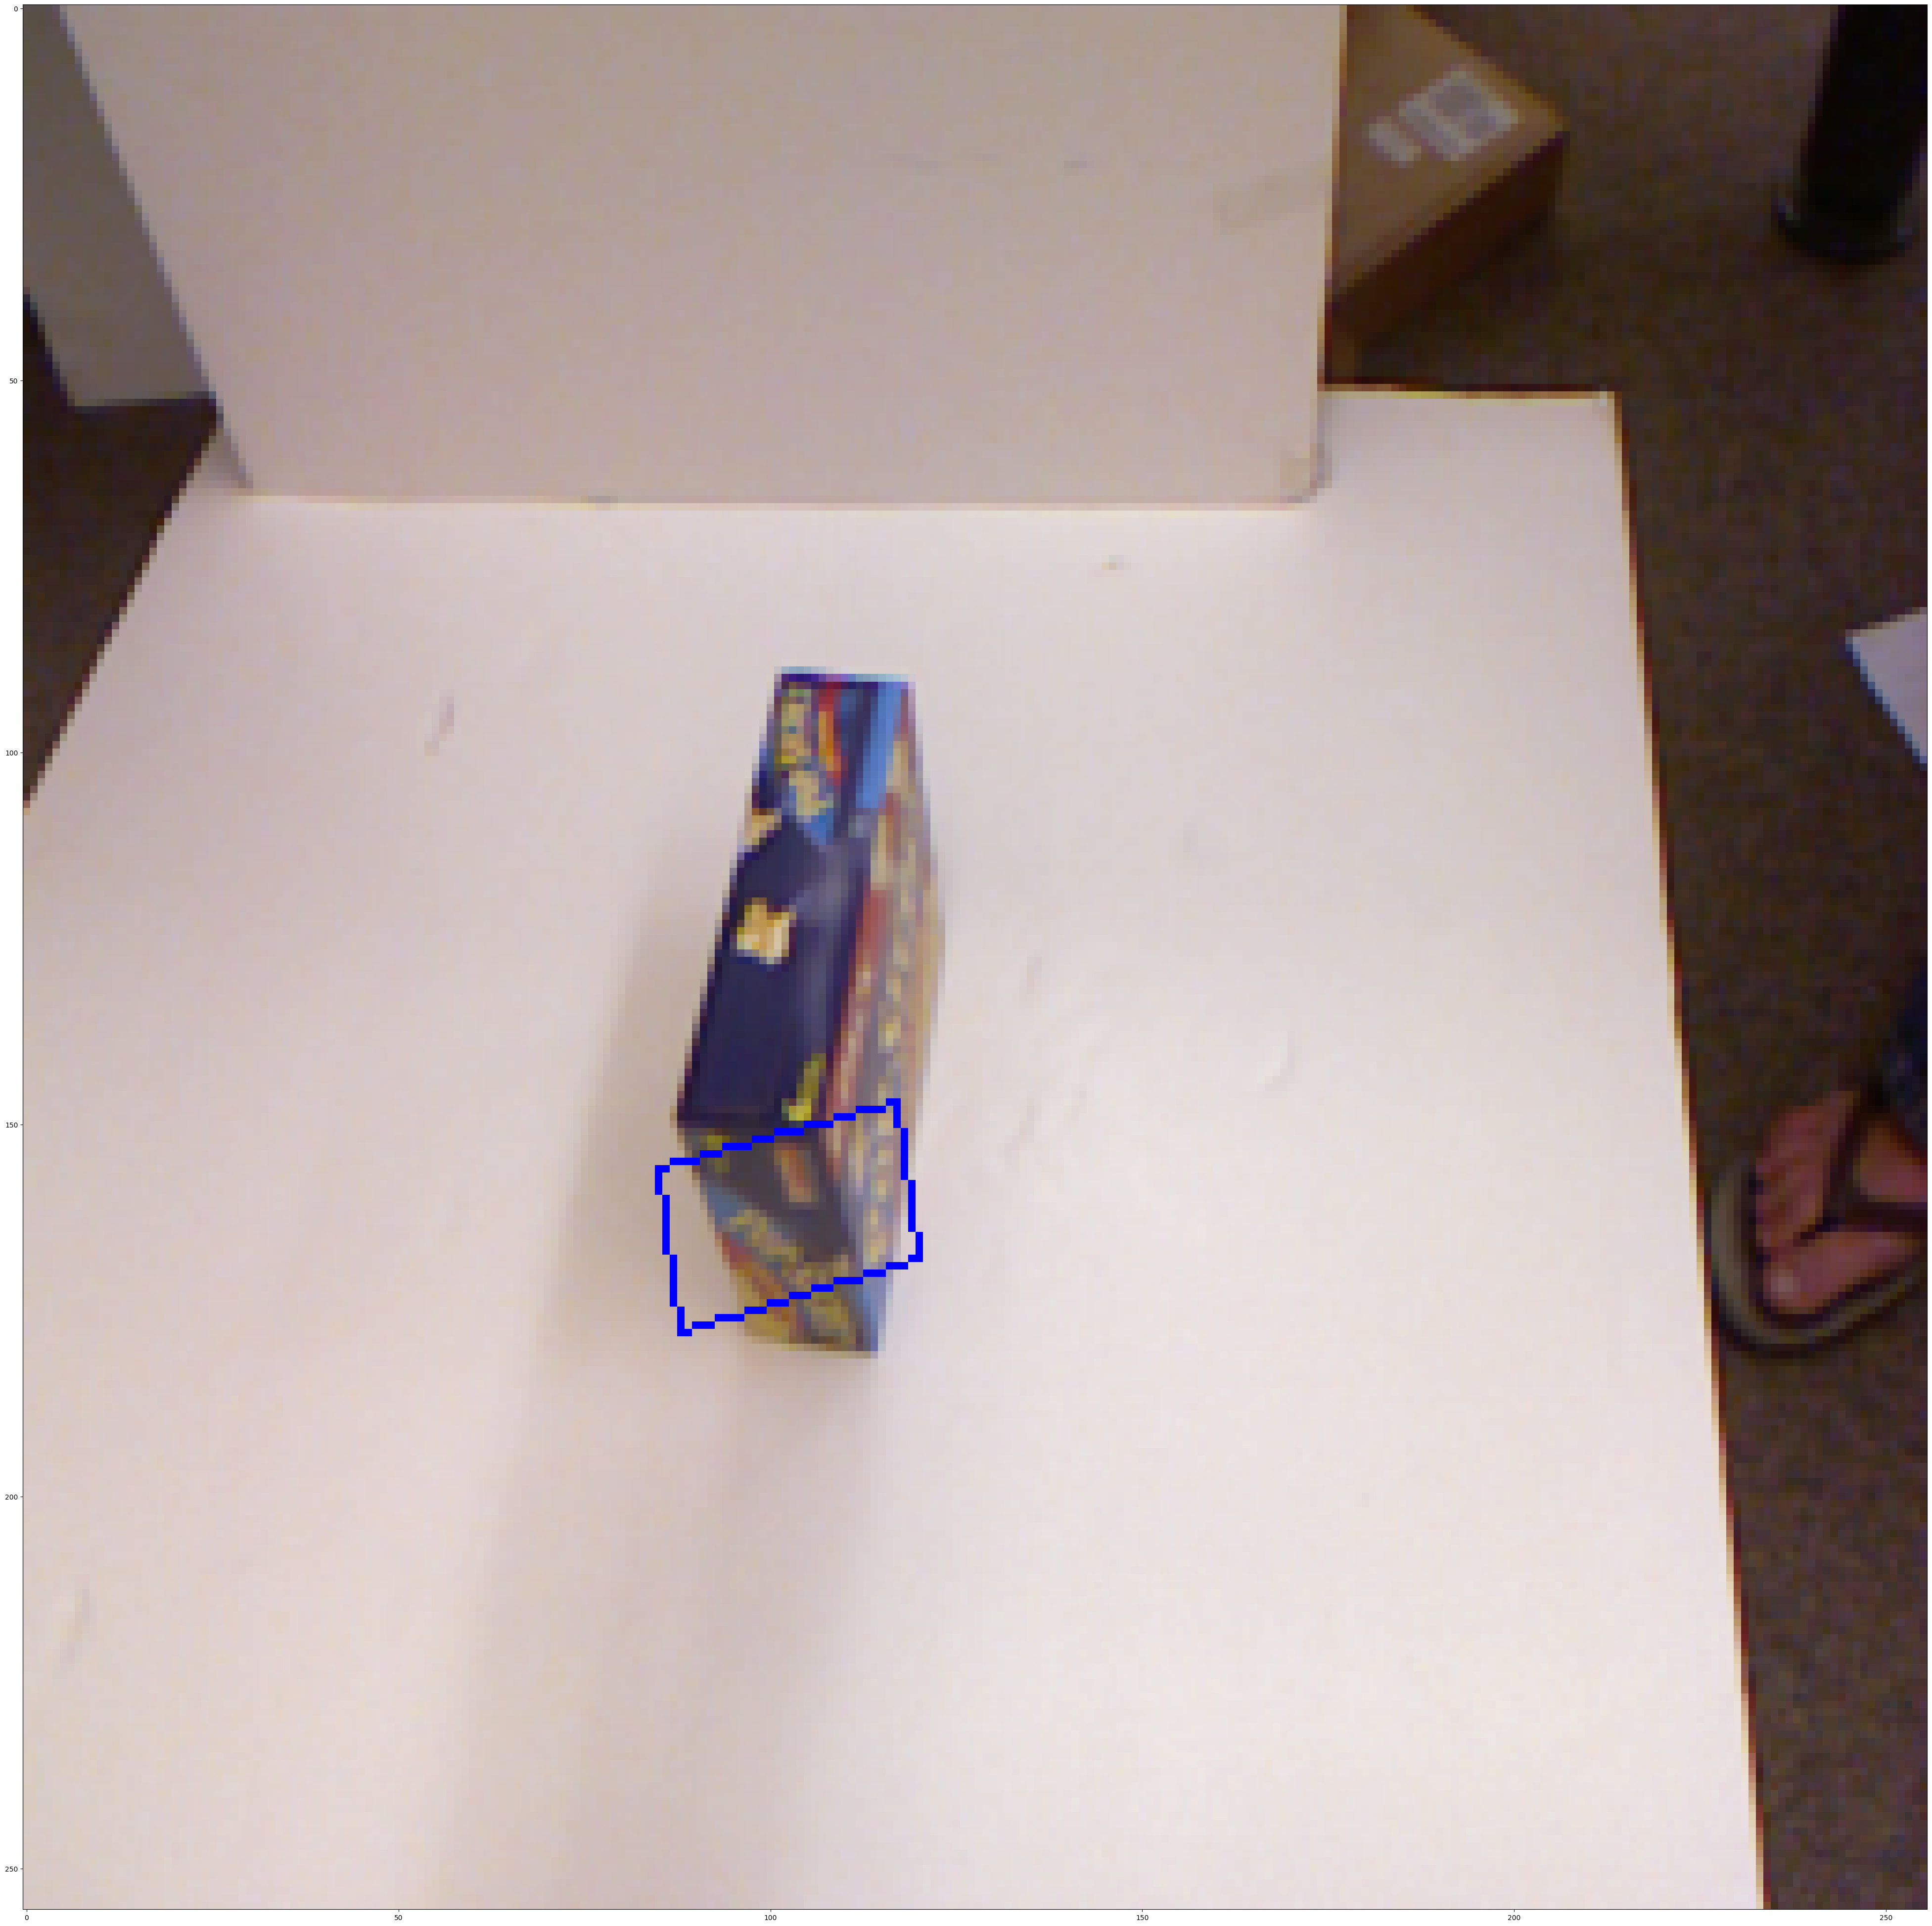

In [96]:
img_t,label_t=transformer(img, torch.tensor(label).view(-1,2),params)

print(label_t)
label_t = torch.squeeze(label_t.view(1,-1)).tolist()

show_img_label(TF.to_pil_image(img_t),label_t)

In [97]:
trans_params_train={
    "target_size" : (256, 256),
    "sample_output" : True
}

In [98]:

trans_params_val={
    "target_size" : (256, 256), 
    "sample_output" : False
}

In [99]:

train_ds = Cornell_Grasp_dataset(path2data,transformer,trans_params_train)
val_ds = Cornell_Grasp_dataset(path2data,transformer,trans_params_val)

from sklearn.model_selection import ShuffleSplit
sss = ShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
indices=range(len(train_ds))

for train_index, val_index in sss.split(indices):
    print(len(train_index))
    print("-"*10)
    print(len(val_index))  

619
----------
266


In [100]:
from torch.utils.data import Subset

train_ds = Subset(train_ds,train_index)
print(len(train_ds))

val_ds = Subset(val_ds,val_index)
print(len(val_ds))

619
266


In [101]:

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# fix random seed
np.random.seed(0)

def show(img,label=None):
    npimg = img.numpy().transpose((1,2,0))
    plt.imshow(npimg)
    if label is not None:
        label = label.view(-1,2)
        for point in label:
            x,y= point
            plt.plot(x,y,'b+',markersize=10)

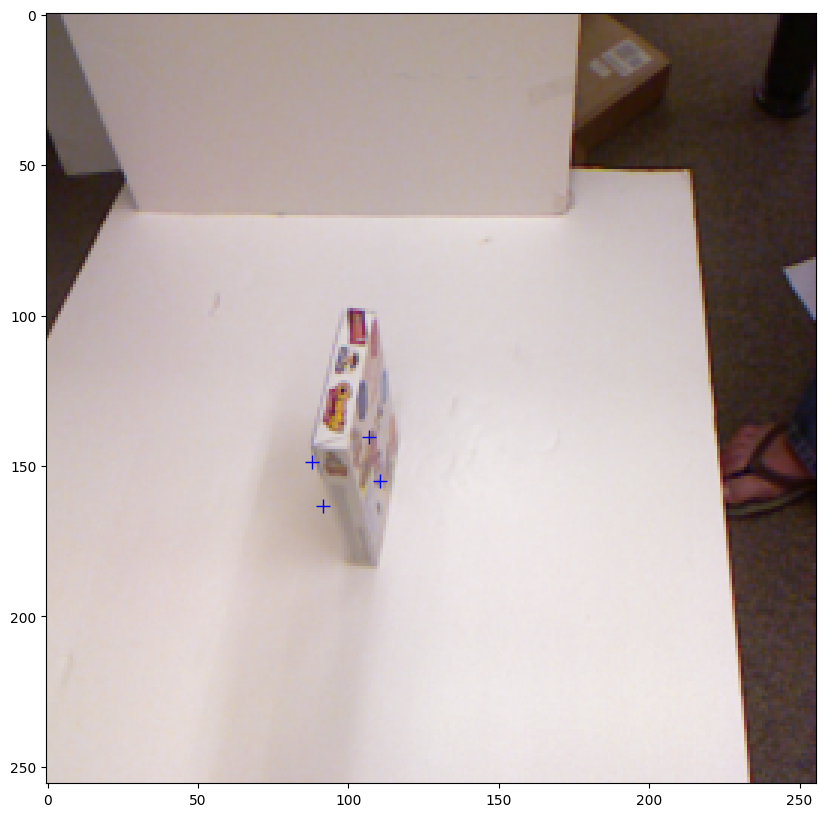

In [102]:

plt.figure(figsize=(10,10))
for img,label in train_ds:
    show(img,label)
    break

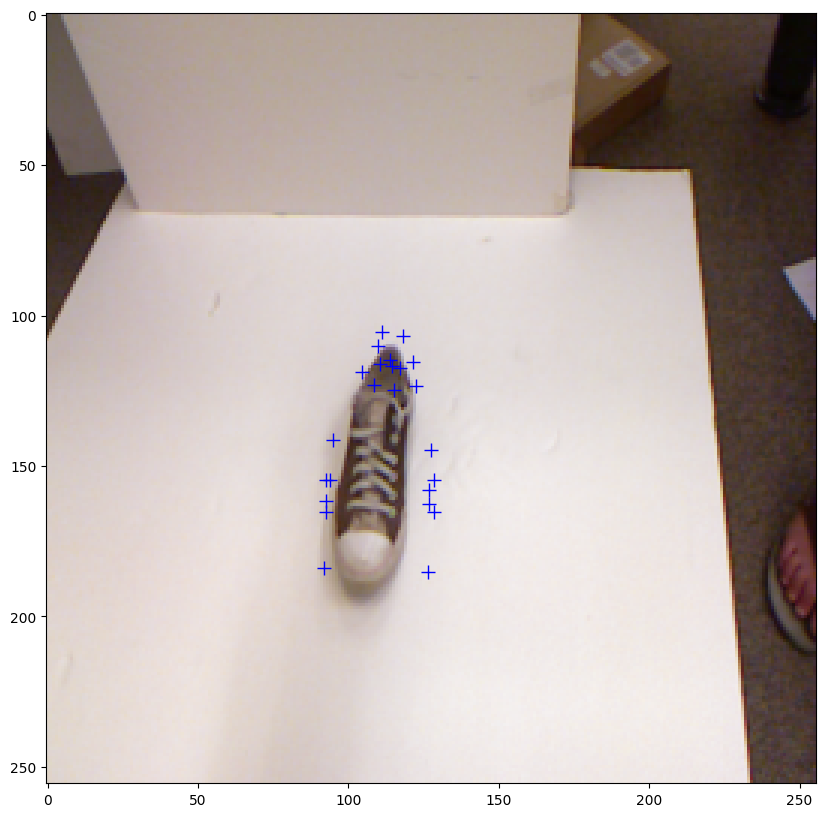

In [103]:
plt.figure(figsize=(10,10))
for img,label in val_ds:
    show(img,label)
    break

In [104]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=266, shuffle=False, collate_fn=collate_fn)

In [105]:
for img_b, label_b in train_dl:
    print(img_b.shape,img_b.dtype)
    print(label_b.shape)
    break

torch.Size([64, 3, 256, 256]) torch.float32
torch.Size([64, 8])


In [106]:
for img, label in val_dl:
    print(label.shape)
    break

torch.Size([1554, 9])



# Create Model

In [107]:
import torch.nn as nn
import torch.nn.functional as F


In [108]:
class Net(nn.Module):
    def __init__(self, params):
        super(Net, self).__init__()
    
    def forward(self, x):
        return x

In [109]:
def __init__(self, params):
    super(Net, self).__init__()

    C_in,H_in,W_in=params["input_shape"]
    init_f=params["initial_filters"] 
    num_outputs=params["num_outputs"] 

    self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3, stride=2, padding=1)
    self.conv2 = nn.Conv2d(init_f+C_in, 2*init_f, kernel_size=3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(3*init_f+C_in, 4*init_f, kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(7*init_f+C_in, 8*init_f, kernel_size=3, padding=1)
    self.conv5 = nn.Conv2d(15*init_f+C_in, 16*init_f, kernel_size=3, padding=1)
    # self.conv6 = nn.Conv2d(31*init_f+C_in, 32*init_f, kernel_size=3, padding=1)
    # self.conv7 = nn.Conv2d(63*init_f+C_in, 64*init_f, kernel_size=3, padding=1)
    # self.conv8 = nn.Conv2d(127*init_f+C_in, 128*init_f, kernel_size=3, padding=1)
    self.fc1 = nn.Linear(16*init_f, num_outputs)
     


In [110]:
def forward(self, x):
    identity=F.avg_pool2d(x,4,4)
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)
    #print("After conv1:", x.shape)

    identity=F.avg_pool2d(x,2,2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)
    # #print("After conv2:", x.shape)

    identity=F.avg_pool2d(x,2,2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)
    # #print("After conv3:", x.shape)
    
    identity=F.avg_pool2d(x,2,2)
    x = F.relu(self.conv4(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)
    # #print("After conv4:", x.shape)

    # identity=F.avg_pool2d(x,2,2)
    x = F.relu(self.conv5(x))
    # x = F.max_pool2d(x, 2, 2)
    # x = torch.cat((x, identity), dim=1)
    # # # # #print("After conv5:", x.shape)

    # identity=F.avg_pool2d(x,2,2)
    # x = F.relu(self.conv6(x))
    # x = F.max_pool2d(x, 2, 2)
    # x = torch.cat((x, identity), dim=1)
    # # # # #print("After conv6:", x.shape)

    # identity=F.avg_pool2d(x,2,2)
    # x = F.relu(self.conv7(x))
    # x = F.max_pool2d(x, 2, 2)
    # x = torch.cat((x, identity), dim=1)

    # x = F.relu(self.conv8(x))
    x=F.adaptive_avg_pool2d(x,1)
    x = x.reshape(x.size(0), -1)
    x = self.fc1(x)
    
    return x

In [111]:
Net.__init__=__init__
Net.forward=forward

In [112]:
params_model={
        "input_shape": (3,256,256),
        "initial_filters": 16, 
        "num_outputs": 5,
            }

model = Net(params_model)

In [113]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    model=model.to(device)

In [114]:
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(19, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(51, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(115, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(243, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=256, out_features=5, bias=True)
)


# Define loss function

In [115]:
# transform function 
def bboxes_to_grasps(bboxes):
    # convert bbox to grasp representation -> tensor([x, y, theta, h, w])
    x = bboxes[:,0] + (bboxes[:,4] - bboxes[:,0])/2
    y = bboxes[:,1] + (bboxes[:,5] - bboxes[:,1])/2 
    theta = torch.atan((bboxes[:,3] -bboxes[:,1]) / (bboxes[:,2] -bboxes[:,0]))
    w = torch.sqrt(torch.pow((bboxes[:,2] -bboxes[:,0]), 2) + torch.pow((bboxes[:,3] -bboxes[:,1]), 2))
    h = torch.sqrt(torch.pow((bboxes[:,6] -bboxes[:,0]), 2) + torch.pow((bboxes[:,7] -bboxes[:,1]), 2))
    grasps = torch.stack((x, y, theta, h, w), 1)
    return grasps

def grasps_to_bboxes(grasps):
    # convert grasp representation to bbox
    x = grasps[:,0]
    y = grasps[:,1]
    theta = grasps[:,2]
    h = grasps[:,3]
    w = grasps[:,4]
    x1 = x -w/2*torch.cos(theta) +h/2*torch.sin(theta)
    y1 = y -w/2*torch.sin(theta) -h/2*torch.cos(theta)
    x2 = x +w/2*torch.cos(theta) +h/2*torch.sin(theta)
    y2 = y +w/2*torch.sin(theta) -h/2*torch.cos(theta)
    x3 = x +w/2*torch.cos(theta) -h/2*torch.sin(theta)
    y3 = y +w/2*torch.sin(theta) +h/2*torch.cos(theta)
    x4 = x -w/2*torch.cos(theta) -h/2*torch.sin(theta)
    y4 = y -w/2*torch.sin(theta) +h/2*torch.cos(theta)
    bboxes = torch.stack((x1, y1, x2, y2, x3, y3, x4, y4), 1)
    return bboxes
    

In [116]:
# test transform function
for img, label in train_dl:
    print(label)
    print(label.shape)
    
    grasps = bboxes_to_grasps(label)
    print(grasps)
    print(grasps.shape)
    
    x = grasps_to_bboxes(grasps)
    print(x)
    print(x.shape)
    
    y = bboxes_to_grasps(x)
    print(y)
    print(y.shape)
    
    
    break

tensor([[115.2000, 139.7461, 145.2000, 132.2795, 143.2000, 117.3333, 113.2000,
         124.8000],
        [136.0000, 189.4507, 145.6000, 179.2000, 139.2000, 168.5333, 129.6000,
         178.7840],
        [139.2000, 137.5589, 137.6000, 147.2000, 145.6000, 149.3333, 147.2000,
         139.6923],
        [115.2000, 129.5419, 140.8000, 137.0085, 144.0000, 117.3333, 118.4000,
         109.8667],
        [117.2000, 170.5643, 121.2000, 184.5333, 127.6000, 181.3333, 123.6000,
         167.3643],
        [119.2000, 138.8549, 117.2000, 150.4000, 126.8000, 153.6000, 128.8000,
         142.0549],
        [110.8000, 122.5061, 156.4000, 138.5061, 161.6000, 111.4667, 116.0000,
          95.4667],
        [148.4000, 156.8000, 120.0000, 156.8000, 120.0000, 144.0000, 148.4000,
         144.0000],
        [132.4000, 146.4709, 121.2000, 150.9333, 118.8000, 140.2667, 130.0000,
         135.8043],
        [101.2000, 169.0139, 117.6000, 176.0000, 114.0000, 190.9333,  97.6000,
         183.9472],
        [1

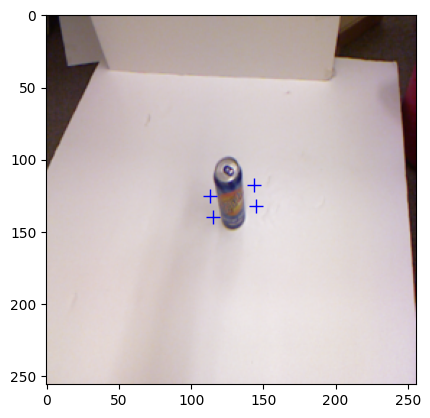

In [117]:
show(img[0], label[0])

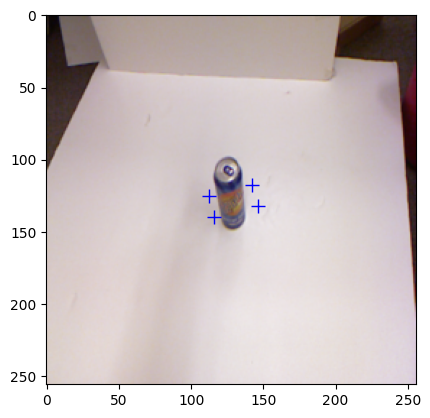

In [118]:
show(img[0], x[0])

In [119]:
import torchvision
from shapely.geometry import Polygon
from math import pi 

def box_iou(bbox_value, bbox_target):
    p1 = Polygon(bbox_value.view(-1,2).tolist())
    p2 = Polygon(bbox_target.view(-1,2).tolist())
    iou = p1.intersection(p2).area / (p1.area +p2.area -p1.intersection(p2).area) 
    return iou



def metrics_batch(output, target):
    pre_bboxes = grasps_to_bboxes(output)
    count = 0
    if target.shape[1] == 8:
        target_grasps = bboxes_to_grasps(target)  
        for i in range(len(output)):  
            iou = box_iou(pre_bboxes[i], target[i])
            pre_theta = output[i][2]
            target_theta = target_grasps[i][2]
            angle_diff = torch.abs(pre_theta - target_theta)*180/pi
            if angle_diff < 30 and iou > 0.001:
                count = count + 1
    else:
        good = [0 for i in range(len(output))]
        all_grasps = bboxes_to_grasps(target[:, 1:])
        for i in range(len(target)):
            index = target[i][0].int()
            if good[index] == 1:
                continue
            iou = box_iou(pre_bboxes[index], target[i][1:])
            pre_theta = output[index][2]
            target_theta = all_grasps[i][2]
            angle_diff = torch.abs(pre_theta - target_theta)*180/pi
            if angle_diff < 30 and iou > 0.001:
                good[index] = 1
        for flag in good:
            if flag == 1:
                count = count + 1
        
    return count

In [120]:
for img, label in train_dl:
    grasps = bboxes_to_grasps(label)
    bboxes = grasps_to_bboxes(grasps)
    print(box_iou(label[0], bboxes[0]))   
    print(metrics_batch(grasps, label))
    break

0.9926465995570042
64


In [121]:
for img, label in val_dl:
    bboxes = torch.rand(img.shape[0], 8)
    for box in label:
        bboxes[box[0].int()] = box[1:]
    grasps = bboxes_to_grasps(bboxes)
    bboxes_new = grasps_to_bboxes(grasps)
    print(box_iou(bboxes_new[0], bboxes[0]))   
    print(metrics_batch(grasps, label))
    break

0.9953954354800537
266


In [122]:

def train_loss_batch(output,targets, params_loss, opt=None):  
    mse_loss = params_loss["mse_loss"]
    gama = params_loss["gama"]
    grasps = bboxes_to_grasps(targets)
    loss_x =mse_loss(output[:,0], grasps[:,0])
    loss_y =mse_loss(output[:,1], grasps[:,1])
    loss_h =mse_loss(output[:,3], grasps[:,3])
    loss_w =mse_loss(output[:,4], grasps[:,4])
    loss_theta = mse_loss(output[:,2], grasps[:,2])
    loss = loss_x + loss_y + loss_h + loss_w + gama*loss_theta
        
    # get performance metric
    metric_b = metrics_batch(output,targets)
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

In [123]:
a = torch.tensor([[1.0,3], [1, 1, ]])
a.mean()

tensor(1.5000)

In [124]:
def val_loss_batch(output,targets, params_loss):  
    loss = 0.0
    gama = params_loss["gama"]
    
    for index, grasp in enumerate(output):
        target = [g[1:] for g in targets if g[0].int() == index]
        target = torch.stack(target)
        target_grasps = bboxes_to_grasps(target)
        loss_x = torch.pow((target_grasps[:,0] - grasp[0]), 2).mean()
        loss_y = torch.pow((target_grasps[:,1] - grasp[1]), 2).mean()
        loss_h = torch.pow((target_grasps[:,3] - grasp[3]), 2).mean()
        loss_w = torch.pow((target_grasps[:,4] - grasp[4]), 2).mean()
        loss_theta = torch.pow((target_grasps[:,2] - grasp[2]), 2).mean()
        loss = loss + loss_x + loss_y + loss_h + loss_w + gama*loss_theta
        
    # get performance metric
    metric_b = metrics_batch(output,targets)
    

    return loss, metric_b

In [125]:
def loss_epoch(model, params_loss, dataset_dl, sanity_check=False, opt=None, training=True):
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl.dataset)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for xb, yb in dataset_dl:
        yb=yb.to(device)
        
        # get model output
        output=model(xb.to(device))
        
        # get loss per batch
        if training:
            loss_b,metric_b = train_loss_batch(output, yb, params_loss, opt)
        else:
            loss_b,metric_b = val_loss_batch(output, yb, params_loss)
        
        # update running loss
        running_loss+=loss_b
        
        # update running metric
        running_metric += metric_b
        
        if sanity_check:
            break

    # average loss value
    loss = running_loss/float(len_data)
    
    # average metric value
    metric = running_metric/float(len_data)
    
    return loss, metric

In [126]:
from torch import optim
opt = optim.Adam(model.parameters(), lr=3e-4)

def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)



In [127]:
# training loop
import copy
def train_val(model, params):
    num_epochs=params["num_epochs"]
    params_loss=params["params_loss"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
    # history of loss values in each epoch
    loss_history={
        "train": [],
        "val": [],
    }
    
    # histroy of metric values in each epoch
    metric_history={
        "train": [],
        "val": [],
    }    
    
    
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # initialize best loss to a large value
    best_loss=float('inf')    
    
    for epoch in range(num_epochs):
        # get current learning rate
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))   

        # train the model
        model.train()
        train_loss, train_metric=loss_epoch(model,params_loss,train_dl,sanity_check,opt)

        # collect loss and metric for training dataset
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        # evaluate the model
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,params_loss,val_dl,sanity_check, training=False)
       
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)   
        
        
        # store best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
            
        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 
            

        print("train loss: %.6f, accuracy: %.4f" %(train_loss*(40/11),100*train_metric))
        print("val loss: %.6f, accuracy: %.4f" %(val_loss*(40/11),100*val_metric))
        print("-"*10) 
        

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [128]:
opt = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

path2models= "../models/"
if not os.path.exists(path2models):
        os.mkdir(path2models)

mse_loss = nn.MSELoss(reduction="sum")

params_loss={
    "mse_loss": mse_loss,
    "gama": 5.0,
}

params_train={
    "num_epochs": 100,
    "optimizer": opt,
    "params_loss": params_loss,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "sanity_check": True,
    "lr_scheduler": lr_scheduler,
    "path2weights": path2models+"weights.pt",
}

import time

# Start the timer
start_time = time.time()

model, loss_hist, metric_history = train_val(model, params_train)

# End the timer
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"Time taken to execute train_val: {elapsed_time:.2f} seconds")

Epoch 0/99, current lr=0.001


Copied best model weights!
train loss: 14270.954619, accuracy: 0.0000
val loss: 134678.968750, accuracy: 0.0000
----------
Epoch 1/99, current lr=0.001
Copied best model weights!
train loss: 14583.705390, accuracy: 0.0000
val loss: 132999.500000, accuracy: 0.0000
----------
Epoch 2/99, current lr=0.001
Copied best model weights!
train loss: 13710.856220, accuracy: 0.0000
val loss: 129677.375000, accuracy: 0.0000
----------
Epoch 3/99, current lr=0.001
Copied best model weights!
train loss: 13324.074020, accuracy: 0.0000
val loss: 123745.289062, accuracy: 0.0000
----------
Epoch 4/99, current lr=0.001
Copied best model weights!
train loss: 13165.044794, accuracy: 0.0000
val loss: 114010.148438, accuracy: 0.0000
----------
Epoch 5/99, current lr=0.001
Copied best model weights!
train loss: 11890.724042, accuracy: 0.0000
val loss: 98933.375000, accuracy: 0.0000
----------
Epoch 6/99, current lr=0.001
Copied best model weights!
train loss: 9968.797915, accuracy: 0.0000
val loss: 77292.8593

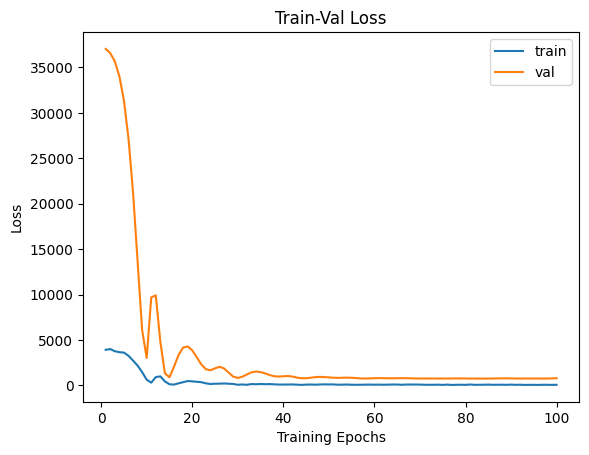

In [129]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
#plt.xticks(range(1, num_epochs+1))
plt.legend()
plt.show()

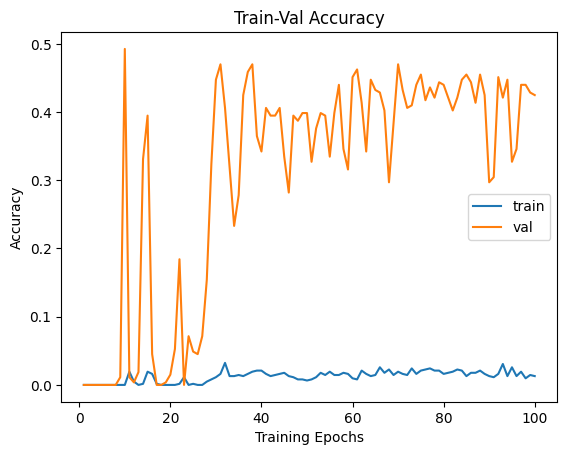

In [130]:
# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_history["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_history["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
#plt.xticks(range(1, num_epochs+1))
plt.legend()
plt.show()